In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [2]:
bins = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340]
count= [18, 16, 25, 44, 58, 69, 80, 77, 78, 104, 65, 60, 43, 42, 25, 6, 3]

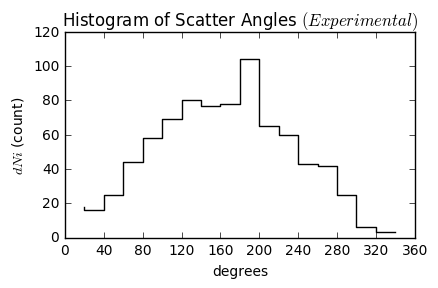

In [3]:
plt.figure(figsize=(4.5,3))
plt.step(bins, count ,color="black")#, width=20, color='gray')
plt.title(r"Histogram of Scatter Angles $(Experimental)$")
plt.xlabel("degrees")
plt.ylabel("$dNi$ (count)")
plt.xticks(np.arange(0,361,40))
plt.xlim(0,360)
plt.tight_layout()
plt.show()

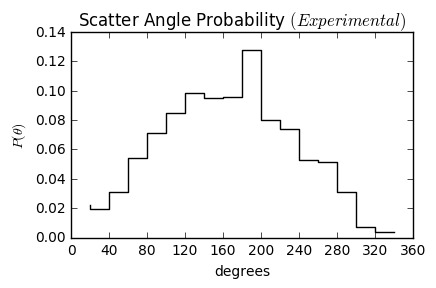

In [4]:
plt.figure(figsize=(4.5,3))
plt.step(bins, np.array(count)/float(sum(count)), color='black')
plt.title(r"Scatter Angle Probability $(Experimental)$")
plt.xlabel("degrees")
plt.ylabel(r"$P (\theta)$")
plt.xticks(np.arange(0,361,40))
plt.xlim(0,360)
plt.tight_layout()
plt.show()

In [5]:
# Simulation of scatter angles
r = 1
b = np.random.uniform(-r,r,1000000) #100k
sa = 2 * np.arccos(b/r) * 180 / np.pi # scattering angles
sa = sa + np.ones(len(sa))*10 # for bin symmetry
sa_hist = np.histogram(sa,bins=np.arange(0,361,20))
sim_hist = sa_hist[0]
sim_hist = np.append(sim_hist,0)
sim_hist = np.divide( sim_hist , float( sum(sim_hist) ) )

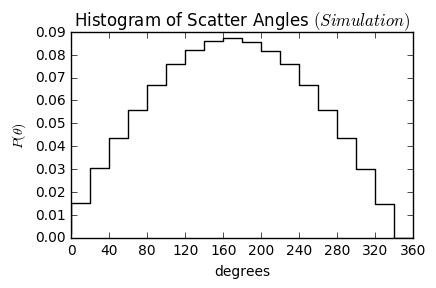

In [6]:
#plt.bar(data.keys(), sim_hist, width=20, color='g')
plt.figure(figsize=(4.5,3))
plt.step(sa_hist[1], sim_hist, color="black")#, width=20, color='g')
plt.title(r"Histogram of Scatter Angles $(Simulation)$")
plt.xlabel("degrees")
plt.ylabel(r"$P (\theta)$")
#plt.xticks(np.arange(0,360,20))
plt.xticks(np.arange(0,361,40))
plt.xlim(0,360)
plt.tight_layout()
plt.show()

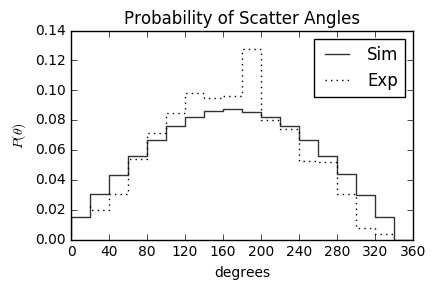

In [7]:
pcount = np.array(count) / float( sum(count) )
#plt.bar(data.keys(), sim_hist, width=20, color='g')
plt.figure(figsize=(4.5,3))
plt.step(sa_hist[1], sim_hist, color="black",alpha=0.8)#, width=20, color='g')
plt.step(bins, pcount , color="black",linestyle="dotted")#, width=20, color='g')
plt.title(r"Probability of Scatter Angles")
plt.xlabel("degrees")
plt.ylabel(r"$P (\theta)$")
#plt.xticks(np.arange(0,360,20))
plt.xticks(np.arange(0,361,40))
plt.xlim(0,360)
plt.tight_layout()
plt.legend(["Sim","Exp"])
plt.show()

In [8]:
# linear fit
incident_flux = 40.0 / 5.2 * 20.0 #40 turns, 5.2 b, 20 shots
x = [np.sin(math.radians(theta) / 2) for theta in bins]
y = count
ys = []
for i in range(len(count)/2+1):
    ys.append(y[i] + y[len(count)-i-1])
fit_data = {
    'x': x[0:9],
    'y': ys
}

lm = smf.ols(formula='y ~ x', data=fit_data).fit()
lm.summary2()

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.936   
Dependent Variable: y                AIC:                75.8861 
Date:               2017-01-01 23:09 BIC:                76.2805 
No. Observations:   9                Log-Likelihood:     -35.943 
Df Model:           1                F-statistic:        117.5   
Df Residuals:       7                Prob (F-statistic): 1.26e-05
R-squared:          0.944            Scale:              221.58  
------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------
Intercept  -33.3821   13.1845  -2.5319  0.0391  -64.5584   -2.2058
x          191.7030   17.6888  10.8375  0.0000  149.8756  233.5304
-----------------------------------------------------------------
Omnibus:              3.240        Durbin-Watson:           1.767
Prob(Omnibus):        0.198        Jarque-Bera (JB):        1.679
Skew:                 1.036        Prob(JB):                0.432
Kurtosis:             2.568        Condition No.:           5    
=================================================================

"""

In [9]:
# cross section
np.array([191.70,17.69,0,149.87,233.53])/incident_flux*4

array([ 4.9842 ,  0.45994,  0.     ,  3.89662,  6.07178])

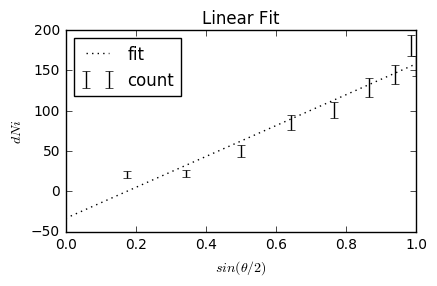

In [10]:
#plot of the fit
plt.figure(figsize=(4.5,3))
plt.errorbar(fit_data['x'], fit_data['y'], np.sqrt(fit_data['y']),fmt='none',ecolor="black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100)*lm.params[1]+lm.params[0],color="k",ls="dotted")
plt.title(r"Linear Fit")
plt.ylabel("$dNi$")
plt.xlabel(r"$sin(\theta/2)$")
plt.legend(["fit","count"],loc="upper left")
plt.tight_layout()
plt.show()

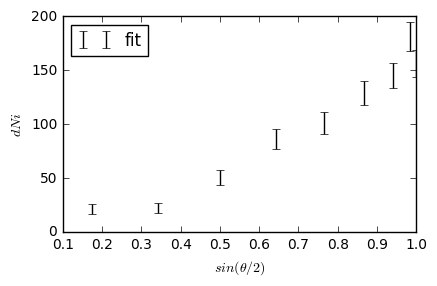

In [11]:
### PART 2 MCMC Sampling ###
# plot of the data we will sample and fit
plt.figure(figsize=(4.5,3))
plt.errorbar(fit_data['x'], fit_data['y'], np.sqrt(fit_data['y']),fmt='none',ecolor="black")
plt.ylabel("$dNi$")
plt.xlabel(r"$sin(\theta/2)$")
plt.legend(["fit","count"],loc="upper left")
plt.tight_layout()
plt.show()

In [12]:
#define the MCMC model
def model(theta, x):
    return theta[0] + theta[1] * x

def ln_likelihood(theta, x, y, dy):
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) + ((y - model(theta, x)) / dy) ** 2)

def ln_prior(theta):
    return 0 # uniform log(1) = 0

def ln_posterior(theta, x, y, dy):
    return ln_prior(theta) + ln_likelihood(theta, x, y, dy)

In [13]:
#define the MCMC Metropolos Hastings function
def run_mcmc(ln_posterior, nsteps, ndim, theta0, stepsize, args=()):
    # Create the array of size (nsteps, ndims) to hold the chain
    # Initialize the first row of this with theta0
    chain = np.zeros((nsteps, ndim))
    chain[0] = theta0
    
    # Create the array of size nsteps to hold the log-likelihoods for each point
    # Initialize the first entry of this with the log likelihood at theta0
    log_likes = np.zeros(nsteps)
    log_likes[0] = ln_posterior(chain[0], *args)
    
    # Loop for nsteps
    for i in range(1, nsteps):
        # Randomly draw a new theta from the proposal distribution.
        # for example, you can do a normally-distributed step by utilizing
        # the np.random.randn() function
        theta_new = chain[i - 1] + stepsize * np.random.randn(ndim)
        
        # Calculate the probability for the new state
        log_like_new = ln_likelihood(theta_new, *args)
        
        # Compare it to the probability of the old state
        # Using the acceptance probability function
        # (remember that you've computed the log probability, not the probability!)
        log_p_accept = log_like_new - log_likes[i - 1]
        
        # Chose a random number r between 0 and 1 to compare with p_accept
        r = np.random.rand()
        
        # If p_accept>1 or p_accept>r, accept the step
        # Else, do not accept the step
        if log_p_accept > np.log(r):
            chain[i] = theta_new
            log_likes[i] = log_like_new
        else:
            chain[i] = chain[i - 1]
            log_likes[i] = log_likes[i - 1]
            
    return chain

In [14]:
x = np.array( fit_data['x'] )
y = np.array( fit_data['y'] )
dy= np.array( np.sqrt(fit_data['y']) )
chain = run_mcmc(ln_posterior, 10000, 2, [0, 0], 0.5, (x, y, dy))

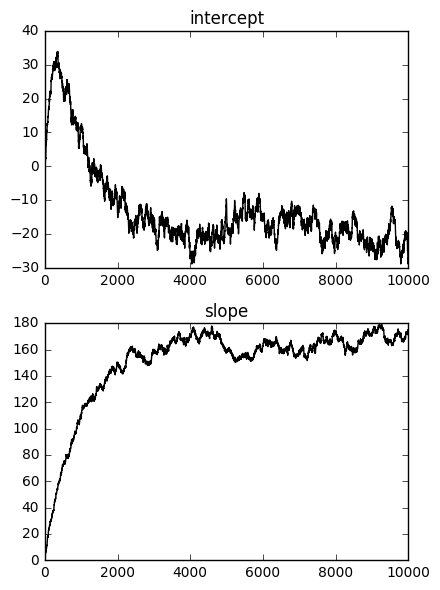

In [15]:
fig, ax = plt.subplots(2,figsize=(4.5,6))
ax[0].plot(chain[:, 0],color="k")
ax[0].set_title('intercept')
ax[1].plot(chain[:, 1],color="k")
ax[1].set_title('slope')
plt.tight_layout()
plt.show()

In [16]:
# Now that we've burned-in, let's get a fresh chain
chain = run_mcmc(ln_posterior, 50000, 2, chain[-1], 0.5, (x, y, dy))

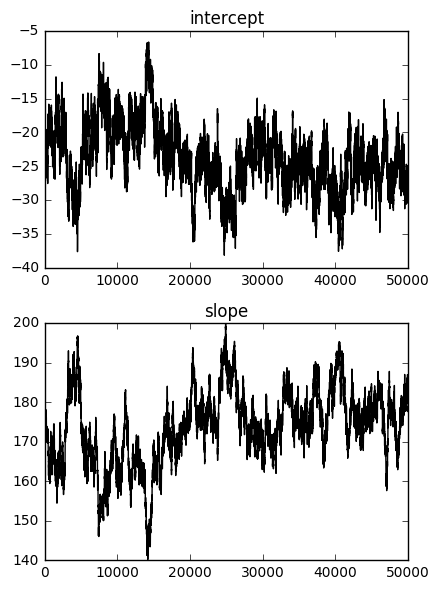

In [17]:
fig, ax = plt.subplots(2,figsize=(4.5,6)) #plt.figure(figsize=(4.5,3))
ax[0].plot(chain[:, 0],color="k")
ax[0].set_title('intercept')
ax[1].plot(chain[:, 1],color="k")
ax[1].set_title('slope')
plt.tight_layout()
plt.show()

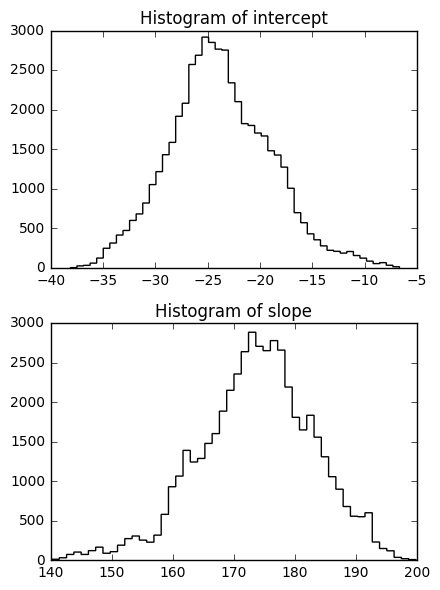

In [18]:
fig, ax = plt.subplots(2,figsize=(4.5,6))
ax[0].hist(chain[:, 0], color="k",histtype="step",bins=50)
ax[0].set_title("Histogram of intercept")
ax[1].hist(chain[:, 1], color="k",histtype="step",bins=50)
ax[1].set_title("Histogram of slope")
plt.tight_layout()
plt.show()

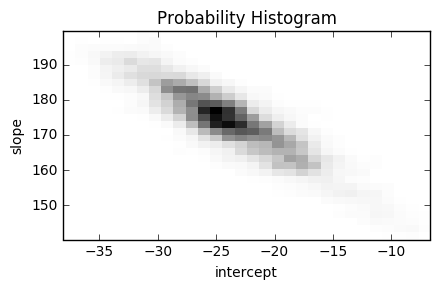

In [19]:
plt.figure(figsize=(4.5,3))
plt.hist2d(chain[:, 0], chain[:, 1], bins=30,
           cmap='Greys')
plt.xlabel('intercept')
plt.ylabel('slope')
plt.title("Probability Histogram")
plt.grid(False)
plt.tight_layout()
plt.show()

In [20]:
print "mean\t",chain[:,1].mean()
print "std\t",chain[:,1].std()

mean	173.724458414
std	9.34630888362


In [21]:
frequ = np.array( [191.7030, 17.688] )
bayes = np.array( [chain[:,1].mean(), chain[:,1].std()] )

frequ = frequ / incident_flux * 4
bayes = bayes / incident_flux * 4

In [22]:
def ynormal(x,mu,sigma):
    return (1/(np.sqrt(2* (sigma**2))*np.pi)) * np.e**(-1*(((x-mu)**2)/(2*sigma**2)))

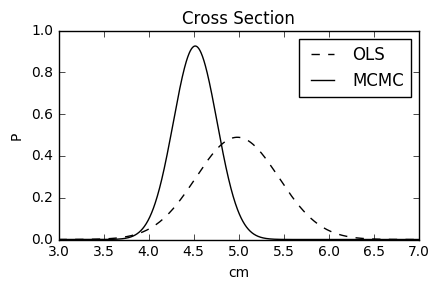

In [23]:
xs = np.linspace(3,7,1000)
f_ys = [ynormal(x,frequ[0],frequ[1]) for x in xs]
b_ys = [ynormal(x,bayes[0],bayes[1]) for x in xs]

plt.figure(figsize=(4.5,3))
plt.plot(xs,f_ys,ls="dashed",color="k")
plt.plot(xs,b_ys,color="k")
plt.title("Cross Section")
plt.xlabel("cm")
plt.ylabel("P")
plt.legend(["OLS","MCMC"])
plt.tight_layout()
plt.show()